# Burgers' Equation

## Preliminary steps

Import modules

In [1]:
%load_ext autoreload
%autoreload 2

from scipy import io
import numpy as np

import matplotlib.pyplot as plt

# plt.style.use("seaborn")

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

Load data

In [2]:
data = io.loadmat("../burgers_data/burgers_data_R10.mat")

Train-test split

In [3]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid

In [4]:
x, y, x_test, y_test, grid = get_data(2048-200, 200)

# further subset the training data

i = 1
x_train = x[i*169: i*169 + 1000]
y_train = y[i*169: i*169 + 1000]

## Model definition

In [20]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

class full_model():
    def __init__(self, n, m, ARD, multiinput, standardise):
        self.n = n
        self.m = m
        self.ARD = ARD
        self.multiinput = multiinput
        self.standardise = standardise

    def fit(self, x_train, y_train, n_samples = None):

        if self.ARD:
            ls = np.ones(self.n)
        else:
            ls = 1.0

        GP_params = {"kernel": gpx.kernels.RBF(lengthscale = ls), 'mean_function': gpx.mean_functions.Zero(), 'multiinput': self.multiinput}

        self.x_train = x_train
        self.y_train = y_train

        if self.m is None:
            self.m = self.y_train.shape[-1]

        self.x_pca = PCA(n_components = self.n)
        self.y_pca = PCA(n_components = self.m)
        self.x_train_pca = self.x_pca.fit_transform(self.x_train)
        self.y_train_pca = self.y_pca.fit_transform(self.y_train)

        self.model_list = []

        if n_samples is not None:
            train_samples_pca = np.zeros((x_train.shape[0], self.m, n_samples))

        if self.standardise:
            self.x_train_pca_stand = (self.x_train_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            self.y_train_pca_stand = (self.y_train_pca - self.y_train_pca.mean(axis = 0))/self.y_train_pca.std(axis = 0)

            if self.multiinput:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand, self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca_stand.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca_stand[:, i].reshape(-1, 1), self.y_train_pca_stand[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)

        else:
            if self.multiinput:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca, self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.y_train_pca.shape[-1])):
                    local_gp = GP_regressor(GP_params=GP_params)
                    local_gp.fit(self.x_train_pca[:, i].reshape(-1, 1), self.y_train_pca[:, i])
                    self.model_list.append(local_gp)
                    if n_samples is not None:
                        train_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_train_pca[:, i].reshape(-1, 1), n_samples = n_samples)
        
        train_samples = np.zeros((self.y_train.shape[0], self.y_train.shape[1], n_samples))

        for i in range(n_samples):
            train_samples_pca_i = train_samples_pca[:, :, i]
            train_samples_i = self.y_pca.inverse_transform(train_samples_pca_i)
            train_samples[:, :, i] = train_samples_i


        if n_samples is not None:
            return train_samples
    
    def predict(self, x_test, n_samples = None):

        self.x_test = x_test

        self.x_test_pca = self.x_pca.transform(x_test)

        if n_samples is not None:
            test_samples_pca = np.zeros((x_test.shape[0], self.m, n_samples))
        
        if self.standardise:
            y_pred_pca_stand = []
            self.x_test_pca_stand = (self.x_test_pca - self.x_train_pca.mean(axis = 0))/self.x_train_pca.std(axis = 0)
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca_stand.append(local_gp.predict(self.x_test_pca_stand[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca_stand[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca_stand = np.stack(y_pred_pca_stand).T
            y_pred_pca = (y_pred_pca_stand * self.y_train_pca.std(axis = 0)) + self.y_train_pca.mean(axis = 0)
        
        else:
            y_pred_pca = []
            if self.multiinput:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca, n_samples = n_samples)
            
            else:
                for i in tqdm(range(self.m)):
                    local_gp = self.model_list[i]
                    y_pred_pca.append(local_gp.predict(self.x_test_pca[:, i].reshape(-1, 1)))
                    if n_samples is not None:
                        test_samples_pca[:, i, :] = local_gp.sample_posterior(self.x_test_pca[:, i].reshape(-1, 1), n_samples = n_samples)
            
            y_pred_pca = np.stack(y_pred_pca).T
        
        y_pred = self.y_pca.inverse_transform(y_pred_pca)

        test_samples = np.zeros((self.x_test.shape[0], self.y_train.shape[1], n_samples))

        for i in range(n_samples):
            test_samples_pca_i = test_samples_pca[:, :, i]
            test_samples_i = self.y_pca.inverse_transform(test_samples_pca_i)
            test_samples[:, :, i] = test_samples_i

        if n_samples is not None:
            return y_pred[:, 0, :], test_samples
        else:
            return y_pred[:, 0, :]

## Train

In [35]:
n_samples = 8

model = full_model(n = 20, m = 20, ARD = True, multiinput = True, standardise = False)
train_samples = model.fit(x_train, y_train, n_samples = n_samples)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  likelihood = like

         Current function value: -974.164246
         Iterations: 42
         Function evaluations: 127
         Gradient evaluations: 115
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.       , 4.9999495, 4.9999804, 4.9999213, 5.       , 4.99999  ,
       5.       , 5.       , 4.9996862, 4.999868 , 4.999989 , 5.       ,
       4.99959  , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.88317543, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
  5%|▌         | 1/20 [00:17<05:25, 17.11s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -969.530945
         Iterations: 25
         Function evaluations: 142
         Gradient evaluations: 131
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.       , 5.       , 5.       , 4.999874 , 4.999945 , 4.999999 ,
       4.999999 , 4.9999847, 4.999944 , 4.9998116, 4.999833 , 4.9992886,
       4.999792 , 4.9997587, 4.999951 , 4.999749 , 4.9999638, 4.9999957,
       4.9999757, 4.9999948], dtype=float32), variance=Array(0.8929119, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000012, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 10%|█         | 2/20 [00:28<04:02, 13.48s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1472.584595
         Iterations: 22
         Function evaluations: 93
         Gradient evaluations: 81
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.       , 4.9999976, 5.       , 4.9999995, 4.9999995, 5.       ,
       4.999998 , 4.9999986, 4.9999976, 4.9999948, 4.9999294, 4.9999156,
       4.999996 , 4.9999943, 4.999994 , 4.999963 , 4.999989 , 4.99998  ,
       4.9999876, 4.99972  ], dtype=float32), variance=Array(0.31194746, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 15%|█▌        | 3/20 [00:37<03:21, 11.86s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1507.626465
         Iterations: 29
         Function evaluations: 154
         Gradient evaluations: 140
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.9999995, 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 4.9999933, 4.9999995, 4.9999995, 5.       , 4.9999995,
       5.       , 5.       , 4.9999585, 4.9999995, 4.999913 , 4.9999986,
       5.       , 4.999971 ], dtype=float32), variance=Array(0.28706992, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 20%|██        | 4/20 [00:52<03:24, 12.76s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1664.777710
         Iterations: 36
         Function evaluations: 192
         Gradient evaluations: 180
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.       , 4.9999995, 4.999999 , 4.999935 , 5.       , 4.9999995,
       4.9999995, 4.9999986, 4.9999995, 4.9999995, 4.9999995, 5.       ,
       4.999554 , 4.9999976, 5.       , 5.       , 5.       , 4.9999995,
       5.       , 5.       ], dtype=float32), variance=Array(0.20358355, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 25%|██▌       | 5/20 [01:16<04:13, 16.93s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1672.922974
         Iterations: 33
         Function evaluations: 161
         Gradient evaluations: 150
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.9999847, 4.9999995, 4.9999995, 4.999848 , 5.       , 4.9999614,
       5.       , 4.999984 , 5.       , 4.9999943, 4.9999995, 4.9999833,
       4.9999943, 4.9999857, 4.9999995, 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.19964743, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 30%|███       | 6/20 [01:33<03:58, 17.01s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1685.646484
         Iterations: 35
         Function evaluations: 233
         Gradient evaluations: 221
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.740737 , 4.676236 , 4.999449 , 5.       , 5.       , 4.999999 ,
       4.999942 , 4.9999933, 5.       , 4.9999995, 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.17093684, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000002, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 35%|███▌      | 7/20 [01:54<03:56, 18.22s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1670.995361
         Iterations: 32
         Function evaluations: 253
         Gradient evaluations: 240
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([4.851434 , 4.9999995, 5.       , 4.999968 , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       4.9999814, 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.19283395, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000001, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 40%|████      | 8/20 [02:12<03:40, 18.34s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1671.385620
         Iterations: 32
         Function evaluations: 113
         Gradient evaluations: 103
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.9178278, 3.835933 , 4.999945 , 4.999985 , 4.999921 , 5.       ,
       4.9999995, 5.       , 4.999917 , 5.       , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.11664724, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000001, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 45%|████▌     | 9/20 [02:26<03:04, 16.80s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated t

         Current function value: -1665.906006
         Iterations: 28
         Function evaluations: 98
         Gradient evaluations: 87
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.7812252, 3.7349086, 4.8471756, 4.9813194, 4.9999557, 4.9987206,
       4.9999995, 4.9999857, 5.       , 4.999999 , 4.9999933, 5.       ,
       4.999992 , 5.       , 4.999998 , 4.9999995, 4.9999757, 4.99999  ,
       4.9999976, 5.       ], dtype=float32), variance=Array(0.10891769, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000146, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 50%|█████     | 10/20 [02:40<02:40, 16.08s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1712.764038
         Iterations: 29
         Function evaluations: 110
         Gradient evaluations: 99
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.2553692, 3.2841637, 4.999925 , 4.323476 , 5.       , 5.       ,
       4.9999933, 4.999996 , 5.       , 4.987198 , 5.       , 5.       ,
       4.999977 , 4.9999743, 4.9999537, 4.9998536, 4.99999  , 4.9999995,
       5.       , 5.       ], dtype=float32), variance=Array(0.06889534, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000024, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 55%|█████▌    | 11/20 [02:53<02:14, 14.94s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1721.305420
         Iterations: 28
         Function evaluations: 106
         Gradient evaluations: 96
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.3550894, 3.2231913, 4.524166 , 4.9987283, 4.999797 , 5.       ,
       5.       , 4.9999986, 4.999994 , 4.9992914, 4.9996166, 4.9999785,
       4.9999847, 4.9999995, 4.9999995, 4.999999 , 4.9999986, 4.9999995,
       5.       , 5.       ], dtype=float32), variance=Array(0.0699811, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000052, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 60%|██████    | 12/20 [03:05<01:54, 14.30s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1792.560425
         Iterations: 34
         Function evaluations: 170
         Gradient evaluations: 157
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.8147132, 2.913321 , 4.401015 , 3.9937649, 4.9999995, 4.999996 ,
       5.       , 5.       , 4.999995 , 5.       , 5.       , 5.       ,
       4.999999 , 5.       , 5.       , 4.9999795, 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.03976851, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000007, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 65%|██████▌   | 13/20 [03:22<01:44, 14.98s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1805.515015
         Iterations: 33
         Function evaluations: 119
         Gradient evaluations: 108
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.9442968, 2.774377 , 4.04718  , 3.9835892, 4.9998374, 5.       ,
       4.999937 , 5.       , 5.       , 4.999996 , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.03694839, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000002, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 70%|███████   | 14/20 [03:37<01:29, 14.97s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1905.390503
         Iterations: 34
         Function evaluations: 102
         Gradient evaluations: 92
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.6282537, 2.487355 , 4.0103774, 3.9875183, 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       4.9999976, 4.9999995, 5.       , 5.       , 5.       , 5.       ,
       5.       , 4.9999943], dtype=float32), variance=Array(0.02373278, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000007, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 75%|███████▌  | 15/20 [03:55<01:19, 15.93s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -1910.323730
         Iterations: 33
         Function evaluations: 97
         Gradient evaluations: 86
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.534718 , 2.5904222, 4.049193 , 3.7357996, 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 4.999999 , 5.       , 5.       , 5.       , 4.999999 ,
       4.9999995, 5.       ], dtype=float32), variance=Array(0.02298049, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000015, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 80%|████████  | 16/20 [04:13<01:05, 16.43s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -2035.392700
         Iterations: 36
         Function evaluations: 126
         Gradient evaluations: 115
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.3245046, 2.3789973, 4.0651617, 3.997192 , 4.9999995, 5.       ,
       5.       , 5.       , 5.       , 5.       , 4.9999995, 5.       ,
       5.       , 4.9999995, 5.       , 5.       , 5.       , 5.       ,
       4.999999 , 5.       ], dtype=float32), variance=Array(0.01507772, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000009, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 85%|████████▌ | 17/20 [04:33<00:53, 17.71s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -2037.206909
         Iterations: 30
         Function evaluations: 163
         Gradient evaluations: 151
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.3705451, 2.1811175, 3.9431596, 3.7468116, 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.01363732, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000009, dtype=float32))


/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
 90%|█████████ | 18/20 [04:52<00:36, 18.10s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated 

         Current function value: -2169.599365
         Iterations: 28
         Function evaluations: 108
         Gradient evaluations: 97
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.1353035, 2.0939891, 4.470554 , 4.220243 , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 4.9999995, 5.       , 5.       , 5.       , 5.       ,
       4.999998 , 5.       ], dtype=float32), variance=Array(0.00974343, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000014, dtype=float32))


 95%|█████████▌| 19/20 [05:09<00:17, 17.53s/it]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:136: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(5e0, dtype=jnp.float64)))
/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:159: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  likeliho

         Current function value: -2187.167725
         Iterations: 30
         Function evaluations: 116
         Gradient evaluations: 105
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.9783592, 2.2024717, 3.721562 , 3.9171576, 5.       , 5.       ,
       4.9999995, 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       , 5.       , 5.       , 5.       , 5.       ,
       5.       , 5.       ], dtype=float32), variance=Array(0.00807995, dtype=float32)), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array(0.01000012, dtype=float32))


100%|██████████| 20/20 [05:26<00:00, 16.32s/it]


## Assess performance on training data

  0%|          | 0/20 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


median relative L2 (train data): 0.005988666824744844
mean relative L2 (train data): 0.009179657097191974


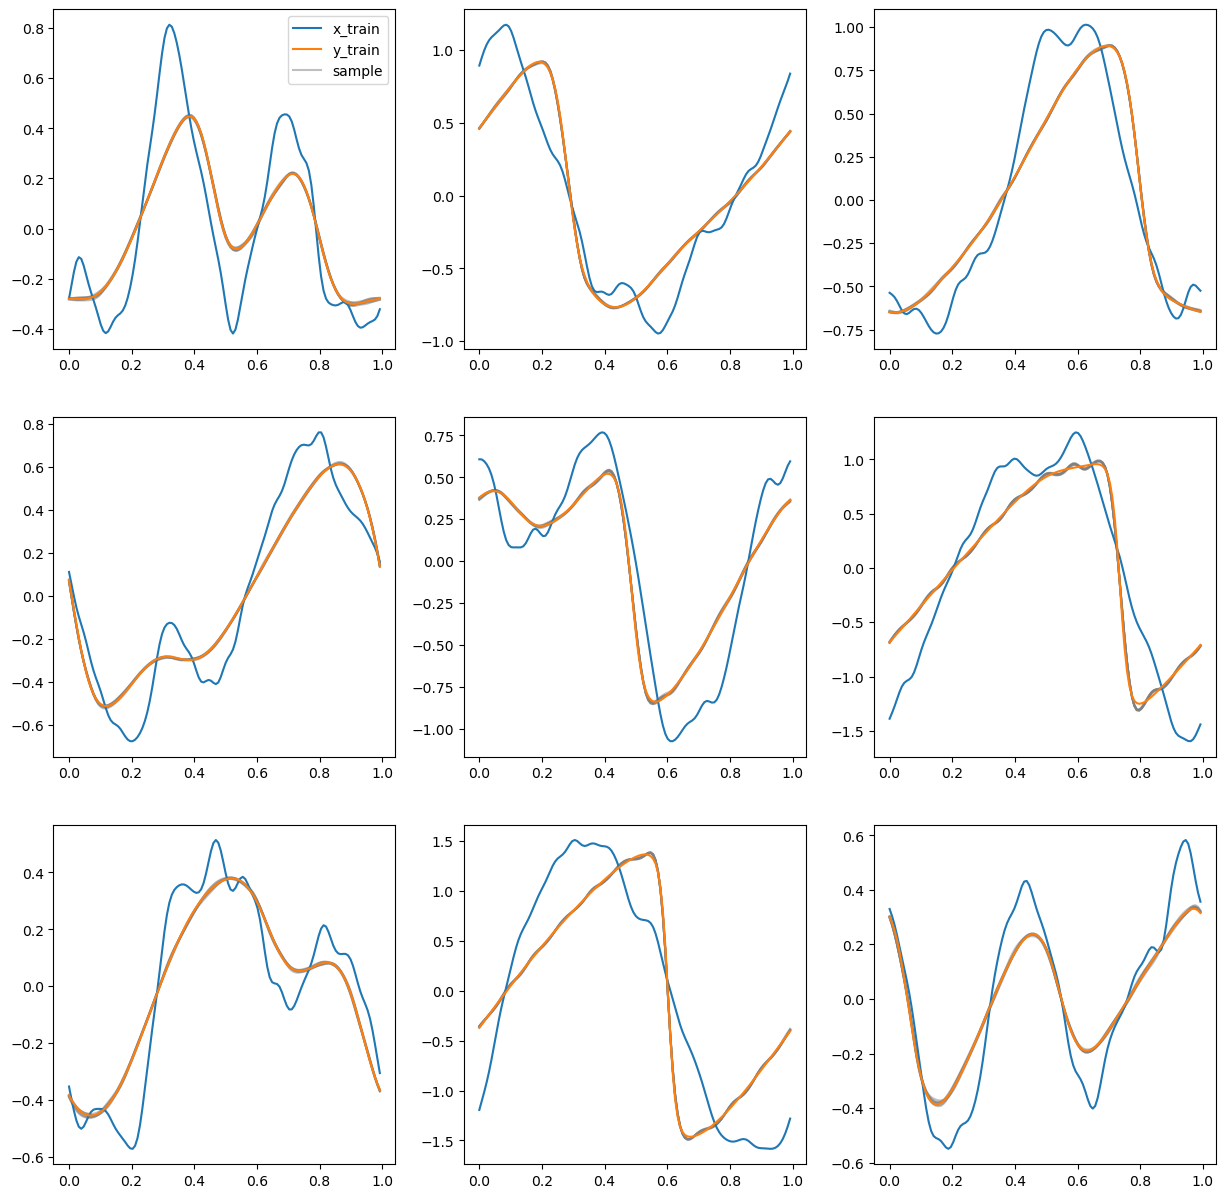

In [36]:
n_samples = 8

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(grid, x_train[i], label='x_train')
    ax[i].plot(grid, y_train[i], label='y_train')
    for j in range(n_samples):
        ax[i].plot(grid, train_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()

## Test

  0%|          | 0/20 [00:00<?, ?it/s]/Users/tomcowperthwaite/Documents/GitHub/MRes/notebooks/../models.py:187: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, n_samples)
100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


median relative L2: 0.017268870315035878
mean relative L2: 0.023798994248465162


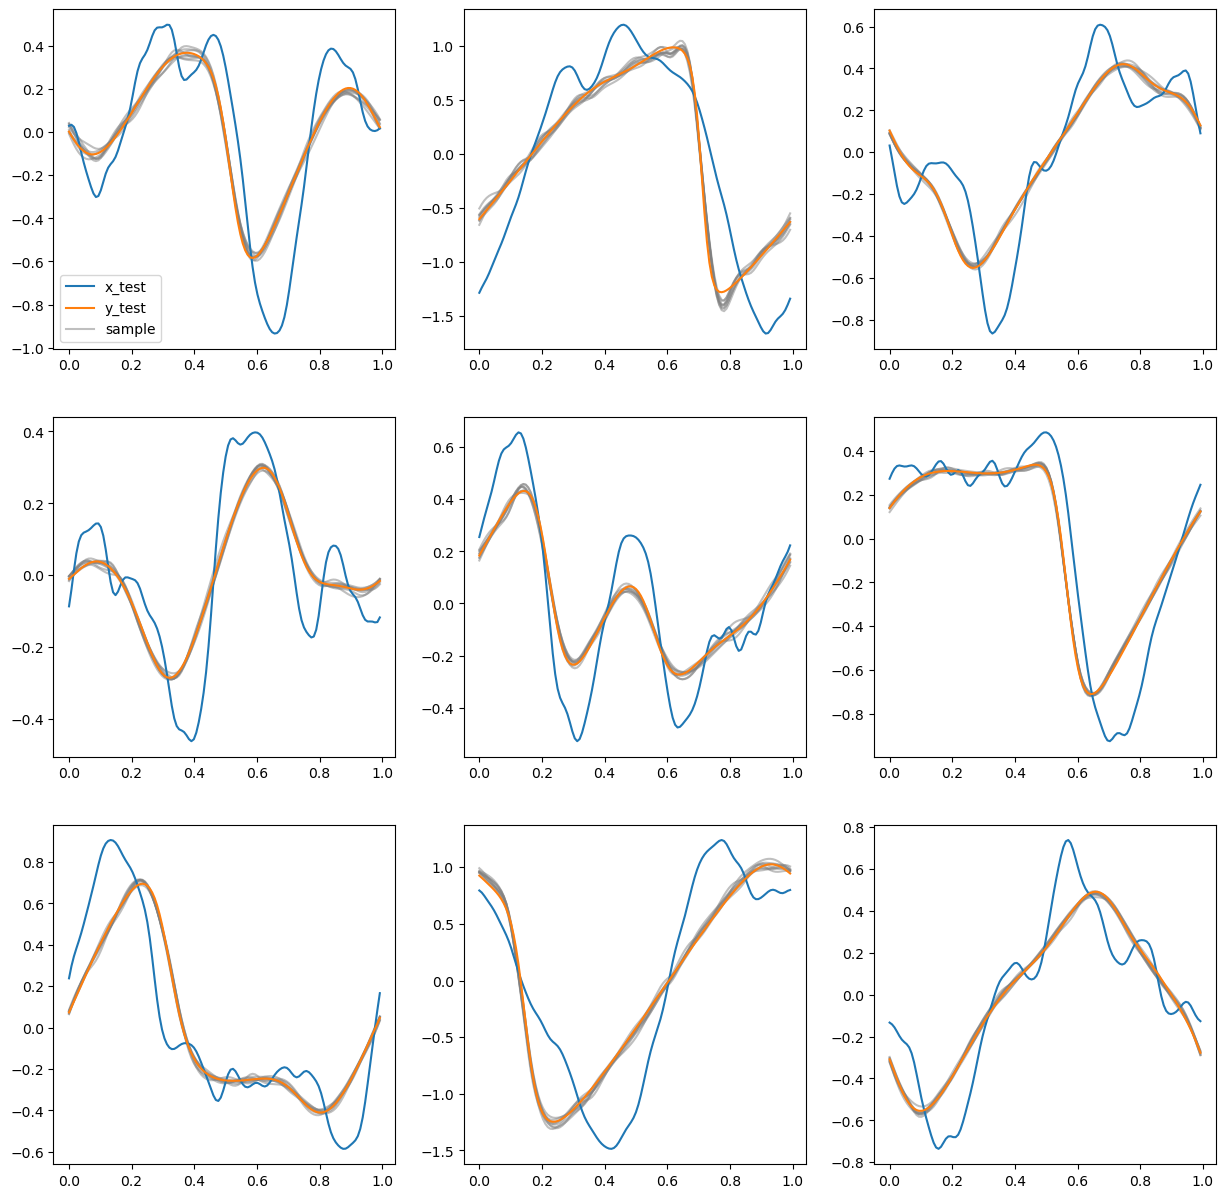

In [37]:
n_samples = 8

y_pred, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(grid, x_test[i], label='x_test')
    ax[i].plot(grid, y_test[i], label='y_test')
    for j in range(n_samples):
        ax[i].plot(grid, test_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()